# Import Libraries

In [1]:
# Load libraries
import numpy as np
from pandas import set_option
set_option('display.max_rows', 500)
set_option('display.max_columns', 500)
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from prophet import Prophet
from datetime import datetime
import pyodbc
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error,r2_score
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Connect to SQL Server

In [2]:
pyodbc.drivers()

['SQL Server',
 'ODBC Driver 17 for SQL Server',
 'SQL Server Native Client RDA 11.0']

In [3]:
connection = pyodbc.connect(
"Driver={ODBC Driver 17 for SQL Server};"
"Server=DESKTOP-ROTIMI\SQLEXPRESS;"
"Database=Rossmann;"
"Trusted_Connection=yes;")

# load dataset

#### Extracting data from SQL Server

In [4]:
# View data from SQL Server
train = pd.read_sql("Select * from [dbo].[train_cleaned]",connection)
test = pd.read_sql("Select * from [dbo].[test_cleaned]",connection)



# Train Table

#### View Data

In [5]:
# head
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,5,5,2015-07-31,4822,559,1,1,0,1
4,6,5,2015-07-31,5651,589,1,1,0,1


In [6]:
# head
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


#### shape of the data

In [7]:
# shape
print(train.shape)


(814299, 9)


In [8]:
# shape
print(test.shape)

(41088, 8)


#### types of the data column

In [9]:
# types
print(train.dtypes)


Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday      int64
SchoolHoliday     int64
dtype: object


In [10]:
# types
print(test.dtypes)

Id                int64
Store             int64
DayOfWeek         int64
Date             object
Open              int64
Promo             int64
StateHoliday      int64
SchoolHoliday     int64
dtype: object


#### data descriptions

In [11]:
# descriptions
train.describe()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,814299.000000,814299.000000,814299.000000,814299.000000,814299.000000,814299.000000,814299.000000,814299.000000
mean,557.386423,3.546504,6578.110456,718.145233,0.999000,0.435819,0.000996,0.192362
std,323.195128,1.714786,2429.153669,306.621660,0.031601,0.495864,0.031543,0.394156
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,277.000000,2.000000,4798.000000,513.000000,1.000000,0.000000,0.000000,0.000000
50%,557.000000,4.000000,6250.000000,663.000000,1.000000,0.000000,0.000000,0.000000
75%,840.000000,5.000000,8078.000000,861.000000,1.000000,1.000000,0.000000,0.000000
max,1115.000000,7.000000,13610.000000,4256.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
# descriptions
test.describe()


,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000
mean,20544.500000,555.899533,3.979167,0.854361,0.395833,0.004381,0.443487
std,11861.228267,320.274496,2.015481,0.352748,0.489035,0.066044,0.496802
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,10272.750000,279.750000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,20544.500000,553.500000,4.000000,1.000000,0.000000,0.000000,0.000000
75%,30816.250000,832.250000,6.000000,1.000000,1.000000,0.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000,1.000000


#### data descriptions

In [13]:
# descriptions
train.describe(include = 'object')


,Date
count,814299
unique,942
top,2013-12-24
freq,1114


In [14]:
# descriptions
test.describe(include = 'object')


,Date
count,41088
unique,48
top,2015-09-17
freq,856


#### Check for missing entries

In [15]:
# Check for missing entries
total = train.isnull().sum().sort_values(ascending=False)
percent=(train.isnull().sum()*100/len(train)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Store,0,0.0
DayOfWeek,0,0.0
Date,0,0.0
Sales,0,0.0
Customers,0,0.0
Open,0,0.0
Promo,0,0.0
StateHoliday,0,0.0
SchoolHoliday,0,0.0


In [16]:
# Check for missing entries
total = test.isnull().sum().sort_values(ascending=False)
percent=(test.isnull().sum()*100/len(test)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Id,0,0.0
Store,0,0.0
DayOfWeek,0,0.0
Date,0,0.0
Open,0,0.0
Promo,0,0.0
StateHoliday,0,0.0
SchoolHoliday,0,0.0


#### Check for duplicate data

In [17]:
# locate rows of duplicate data

# calculate duplicates
dups = train.duplicated()
# report if there are any duplicates
print(dups.any())


False


In [18]:
# locate rows of duplicate data

# calculate duplicates
dups = test.duplicated()
# report if there are any duplicates
print(dups.any())


False


## Basic Prophet With Holidays

#### Rename columns 

In [19]:
# Rename columns for Prophet
train = train.rename(columns={"Date": "ds", "Sales": "y"}).sort_values(by = 'ds')
test = test.rename(columns={"Date": "ds"}).sort_values(by = 'ds')

#### Convert Date to datetime

In [20]:
# Convert Date to datetime
train["ds"] = pd.to_datetime(train["ds"])
test["ds"] = pd.to_datetime(test["ds"])



In [21]:
holiday_dates = train[train["StateHoliday"] == 1]["ds"].unique()

In [22]:
holidays = pd.DataFrame({"holiday" : "store_holiday",
              "ds" : pd.to_datetime(holiday_dates),
                         "lower_window" : 0,
                         "upper_window" : 1 })

#### Groupby to fix Duplicate

In [23]:
# Group by 'Date' and sum sales (fix for duplicate dates)
train = train.groupby("ds", as_index=False).sum()

#### Remove zero values 
###### Sale when it is Open

In [24]:
# Remove zero sales

train = train[train["Open"] != 0]

#### Data Validation : Splitting

In [25]:
# Split data: 80% training, 20% validation
validation_size = 0.20
seed = None
train_set,val_set = train_test_split(train,
test_size=validation_size, random_state=seed,shuffle = False)

In [26]:
train_set.shape,val_set.shape

((753, 9), (189, 9))

#### Train Prophet model

In [27]:
# Train Prophet model
holiday_model = Prophet(holidays = holidays ,
                     yearly_seasonality=True,
                     weekly_seasonality=True,
                     daily_seasonality=False)
holiday_model.add_seasonality(name = "monthly",period = 30.5,fourier_order = 5)
holiday_model.fit(train_set[["ds","y"]])

09:53:45 - cmdstanpy - INFO - Chain [1] start processing
09:53:45 - cmdstanpy - INFO - Chain [1] done processing


#### Predict on validation set

In [28]:
# Predict on validation set
val_forecast = holiday_model.predict(val_set[["ds"]])

#### Print validation results

In [29]:
print("Validation Metrics:")
print("MAE :",mean_absolute_error(val_set["y"], val_forecast["yhat"]))
print("MSE :",mean_squared_error(val_set["y"], val_forecast["yhat"]))
print("RMSE :",root_mean_squared_error(val_set["y"], val_forecast["yhat"]))
print("R2 :",r2_score(val_set["y"], val_forecast["yhat"]))

Validation Metrics:
MAE : 1105479.7745609228
MSE : 1807440526452.8604
RMSE : 1344410.8473427536
R2 : 0.77456058815911


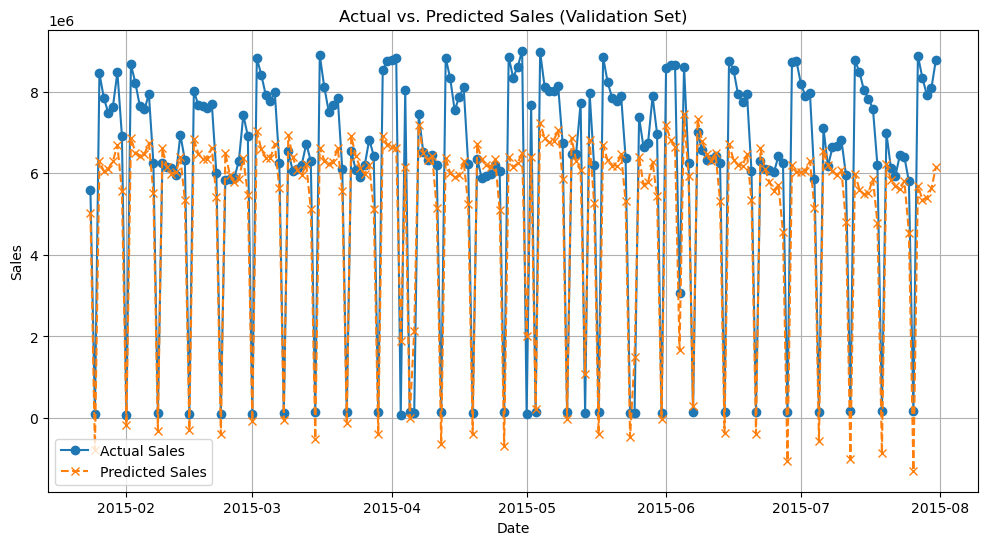

In [30]:
# Plot actual vs. predicted sales for validation set
plt.figure(figsize=(12, 6))

# Actual sales
plt.plot(val_set["ds"], val_set["y"], label="Actual Sales", marker='o', linestyle='-')

# Predicted sales
plt.plot(val_set["ds"], val_forecast["yhat"], label="Predicted Sales", marker='x', linestyle='--')

# Labels and title
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Actual vs. Predicted Sales (Validation Set)")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [31]:
# Forecast on test data
# Rename columns for Prophet
test = test.rename(columns={"Date": "ds"})
test_forecast = holiday_model.predict(test[["ds"]])

In [32]:
# Save test forecast results
test_forecast_summary = test_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
test_forecast_summary.rename(columns={"ds": "Date"}, inplace=True)
test_forecast_summary.to_csv("test_forecast_results.csv", index=False)